# Setup

In [1]:
# Python >=3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >=0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import pandas as pd
assert pd.__version__ >= "0.25"
import seaborn as sns
import numpy as np
import os

# to make this notebook's output stable
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_ID = "iris"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", 
             resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Business Understanding
The *Iris* dataset is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper *The use of multiple measurements in taxonomic problems* as an example of linear discriminant analysis. The data has only 150 rows & 4 columns. *Iris* has 3 species and they are confusing to distinguish with the naked eye.

#### The problem is: predict the class of the flower based on available attributes.

`note`: I will follow CRISP-DM

# Data Aquisition

Let's start with loading iris dataset with sklearn datasets modeule.

In [2]:
from sklearn import datasets
iris = datasets.load_iris()

In [3]:
dir(iris)

['DESCR', 'data', 'feature_names', 'filename', 'target', 'target_names']

For analysis split dataset into train an test set. 

In [4]:
iris_df = pd.DataFrame(np.c_[iris.data, iris.target], 
                       columns=np.concatenate((iris.feature_names,  ["species"])) )

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [5]:
from sklearn.model_selection import train_test_split

# we reserve 25% for test set
X_train, X_test, y_train, y_test = train_test_split(iris_df.iloc[:, :-1], iris_df[['species']],
                                                    test_size=0.25, shuffle=True,
                                                    random_state = 11)

y_train = y_train.values.reshape(-1)
y_test = y_test.values.reshape(-1)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((112, 4), (38, 4), (112,), (38,))

# Data Understanding

In [7]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length (cm)    150 non-null float64
sepal width (cm)     150 non-null float64
petal length (cm)    150 non-null float64
petal width (cm)     150 non-null float64
species              150 non-null float64
dtypes: float64(5)
memory usage: 6.0 KB


In [8]:
iris_df.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
species              0
dtype: int64

Good, we don't have a null value.

In [9]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


Let's see the data with visualization

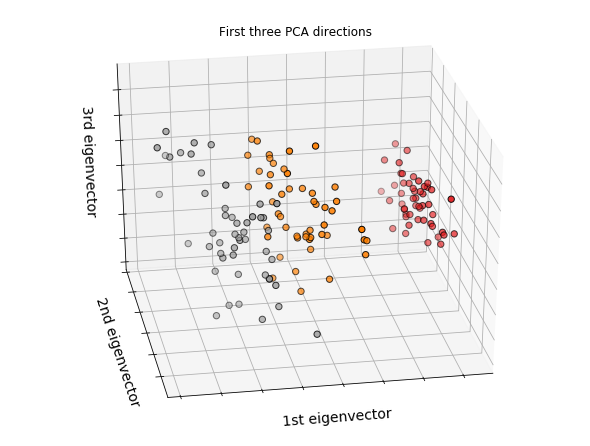

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=100)
X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=iris.target,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([]);

Seems like linear decision boundries could be employed.

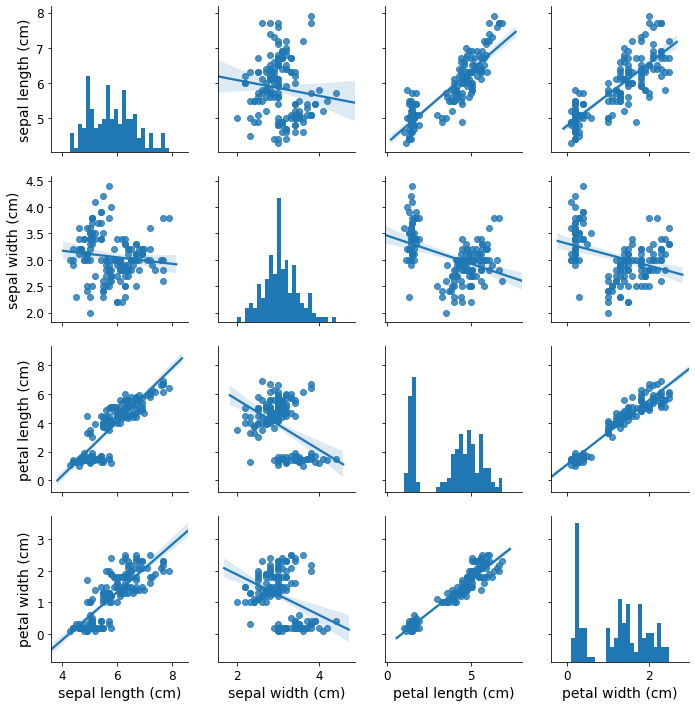

In [11]:
sns.pairplot(iris_df.drop(columns=['species']), diag_kind="hist", 
             kind='reg', diag_kws={'bins':25})
plt.show()

It seems features are correlated. Dimensionality reduction can brings about positive effect.

# Data Preparation
From above pair plot, 'sepal length' and 'sepal width' approximately follows gausian distribution but 'petal length' and 'petal width' are bimodal. Therefore, we use different scaling treatment for two kinds - standardization, minmax normalization. 

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train_scaled = np.zeros_like(X_train)
X_train_scaled[:,:2] = StandardScaler().fit_transform(X_train[['sepal length (cm)', 'sepal width (cm)']])
X_train_scaled[:,2:] = MinMaxScaler((-2, 2)).fit_transform(X_train[['petal length (cm)', 'petal width (cm)']])

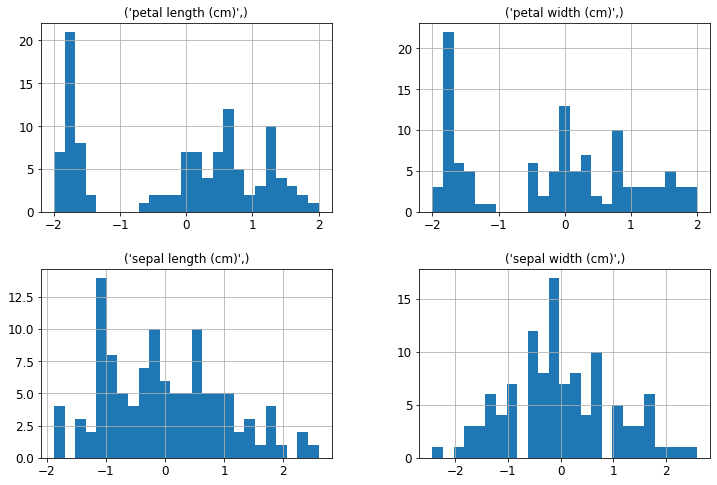

In [13]:
pd.DataFrame(X_train_scaled, columns=[iris.feature_names]).hist(bins=25, figsize=(12, 8))
plt.show();

Now, all feature scales are similar and pre-process distribution shape is preserved. 

Now let's make `pipeline` for preprocessing.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocess_pipeline = ColumnTransformer([
                        ("standard_scaler", StandardScaler(), ['sepal length (cm)', 'sepal width (cm)']),
                        ("minmax_scaler", MinMaxScaler((-2, 2)), ['petal length (cm)', 'petal width (cm)'])
                        ])

In [15]:
np.allclose(preprocess_pipeline.fit_transform(X_train), X_train_scaled)

True

# Modeling
The problem is multiclass classification. Given that, let us try several models with default value quick and dirty. We will consider the following estimators:
- Multiclass Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- Linear Support Vector Machine (LSVM)
- Gaussian Naive Bayes (NB)
- K-Nearest Neighbors (KNN)
- Support Vector Machines (SVM)
- Decision Tree (CART)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Let us see if PCA helps due to collinearity between features. 

In [17]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(X_train_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

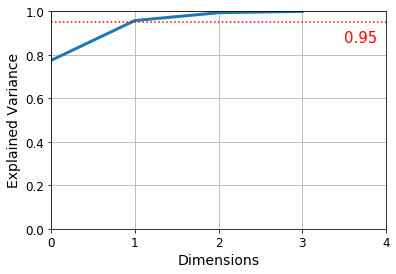

In [18]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 4, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([0, 4], [0.95, 0.95], "r:")
plt.annotate("0.95", xy=(3.5, 0.86), fontsize=15, color='r')

plt.grid(True)
plt.gca().get_xaxis().set_ticks([0, 1, 2, 3, 4])
plt.show()

With 2 principal components, we can explain more than 0.95 variance in the data. This result is aligned with previsous observation of high collinearlity.

In [19]:
X_train_reduced = PCA(n_components=2).fit_transform(X_train_scaled)

In [20]:
## With PCA 
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=42)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('LSVM', LinearSVC(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='scale', random_state=42)))
models.append(('CART', DecisionTreeClassifier(random_state=42)))

results = []
names = []
kfold = KFold(n_splits=5, random_state=42)

for name, model in models:
    cv_results = cross_val_score(model, X_train_reduced, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})"
    print(msg)

LR: 0.8672 (0.0718)
LDA: 0.9198 (0.0435)
LSVM: 0.8755 (0.0499)
NB: 0.9024 (0.0508)
KNN: 0.9024 (0.0634)
SVM: 0.8842 (0.0353)
CART: 0.9194 (0.0186)


In [21]:
## Without PCA
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='ovr', random_state=42)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('LSVM', LinearSVC(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='scale', random_state=42)))
models.append(('CART', DecisionTreeClassifier(random_state=42)))

results = []
names = []
kfold = KFold(n_splits=5, random_state=42)

for name, model in models:
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = f"{name}: {cv_results.mean():.4f} ({cv_results.std():.4f})"
    print(msg)

LR: 0.9300 (0.0705)
LDA: 0.9731 (0.0220)
LSVM: 0.9209 (0.0697)
NB: 0.9648 (0.0508)
KNN: 0.9379 (0.0342)
SVM: 0.9474 (0.0506)
CART: 0.9557 (0.0476)


It is obvious that dimisionality reduction (PCA) does not bring in positive effect on the performance. As we conjected earlier linear model performs better, especially LDA and NB. Interestingly Decision Tree performs pretty good. 
Also, the fact that LDA and NB show good performance means the distributions of features follow Gaussian distribution. Even though the difference is minor (maybe due to the small size of data), that LDA outperforms NB means the hypothesis of features (variables) being independent is less stronger than the hypothesis of sharing same covariance matrix. Given the difference, we can suppose that features are weakly independent from each other. 


Since LDA shows the best performance with default setting. Let us fine-tune LDA hoping better accuracy!

### Fine-tune the model: Grid Search

In [22]:
LinearDiscriminantAnalysis().get_params().keys()

dict_keys(['n_components', 'priors', 'shrinkage', 'solver', 'store_covariance', 'tol'])

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'solver': ['svd']},
    {'solver': ['lsqr', 'eigen'], 'shrinkage' : np.linspace(0, 1, 50)}
]

lda = LinearDiscriminantAnalysis()

grid_search = GridSearchCV(lda, param_grid, cv=5,
                           scoring='accuracy', return_train_score=True)

grid_search.fit(X_train_scaled, y_train);

//miniconda3/envs/venv/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
grid_search.best_params_

{'solver': 'svd'}

In [25]:
grid_search.best_estimator_

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [26]:
grid_search.best_score_

0.9821428571428571

okay, 98.21% accuracy is not bad. However, what we want is model performs as good or better on test set. Let's find out 

# Evaluation

In [27]:
from sklearn.metrics import accuracy_score

lda = grid_search.best_estimator_

X_test_scaled = preprocess_pipeline.transform(X_test)

y_pred = lda.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on test dataset: {accuracy:0.4f}')

Accuracy on test dataset: 0.9737


There is ~0.5% differece which is not very big. 97.4% is pretty good which means the model did not suffer high variance nor bias. 